In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# From 2001 UK census the percentages of households from size 1 to 8 are:
pages = np.array([30.28, 34.07, 15.51, 13.32, 4.88, 1.41, 0.33, 0.20])

In [3]:
weights = pages / np.sum(pages)
nmax = len(weights)
nbar = weights @ np.arange(1,nmax+1)

In [4]:
# INTERPRETABLE PARAMETERS:
latent_period = 5.0 # Days in E class before becoming infectious
prodrome_period = 3.0 # Days infectious but not symptomatic
infectious_period = 4.0 # Days infectious and symptomatic
RGp = 0.5 # Contribution to R0 outside the household from pre-symptomatic
RGi = 1.0 # Contribution to R0 outside the household during symptomatic
eta = 0.8 # Parameter of the Cauchemez model: HH transmission ~ n^(-eta)
import_rate = 0.001 # International importation rate
Npop = 5.6e7 # Total population
SAPp = 0.4 # Secondary attack probability for a two-person household with one susceptible and one prodrome
SAPi = 0.8 # Secondary attack probability for a two-person household with one susceptible and one infective
dist_start = 21 # Start of social distancing
dist_end = 42 # End of social distancing

In [5]:
s2i = np.zeros((nmax+1,nmax+1,nmax+1,nmax+1,nmax+1),dtype=np.int32)

In [6]:
k=0
for n in range(1,nmax+1):
    for s in range(0,n+1):
        for e in range(0,n+1-s):
            for p in range(0,n+1-s-e):
                for i in range(0,n+1-s-e-p):
                    s2i[n-1,s,e,p,i] = k
                    k += 1
imax = k

In [7]:
# Initialise the indices for sparse array generation

Ise_p = np.array([],dtype=np.int32)
Jse_p = np.array([],dtype=np.int32)
Vse_p = np.array([])

Ise_i = np.array([],dtype=np.int32)
Jse_i = np.array([],dtype=np.int32)
Vse_i = np.array([])

Iep = np.array([],dtype=np.int32)
Jep = np.array([],dtype=np.int32)
Vep = np.array([])

Ipi = np.array([],dtype=np.int32)
Jpi = np.array([],dtype=np.int32)
Vpi = np.array([])

Iir = np.array([],dtype=np.int32)
Jir = np.array([],dtype=np.int32)
Vir = np.array([])

ii = np.zeros(imax)
pp = np.zeros(imax)
ptilde = np.zeros(imax)

In [8]:
for n in range(1,nmax+1):
    for s in range(0,n+1):
        for e in range(0,n+1-s):
            for p in range(0,n+1-s-e):
                for i in range(0,n+1-s-e-p):
                    I = s2i[n-1,s,e,p,i]
                    
                    ii[I] = float(i)
                    pp[I] = float(p)
                    
                    if (i==0):
                        ptilde[I] = float(p)

                    if ((s>0) and (p>0)):
                        Ise_p = np.append(Ise_p,I)
                        Jse_p = np.append(Jse_p,s2i[n-1,s-1,e+1,p,i])
                        val = float(s*p)/(float(n)**(-eta)) # CAUCHEMEZ MODEL
                        Vse_p = np.append(Vse_p,val)
                        Ise_p = np.append(Ise_p,I)
                        Jse_p = np.append(Jse_p,I)
                        Vse_p = np.append(Vse_p,-val)      
                    if ((s>0) and (i>0)):
                        Ise_i = np.append(Ise_i,I)
                        Jse_i = np.append(Jse_i,s2i[n-1,s-1,e+1,p,i])
                        val = float(s*i)/(float(n)**(-eta)) # CAUCHEMEZ MODEL
                        Vse_i = np.append(Vse_i,val)
                        Ise_i = np.append(Ise_i,I)
                        Jse_i = np.append(Jse_i,I)
                        Vse_i = np.append(Vse_i,-val)                   
                    if (e>0):
                        Iep = np.append(Iep,I)
                        Jep = np.append(Jep,s2i[n-1,s,e-1,p+1,i])
                        val = float(e)
                        Vep = np.append(Vep,val)
                        Iep = np.append(Iep,I)
                        Jep = np.append(Jep,I)
                        Vep = np.append(Vep,-val)
                    if (p>0):
                        Ipi = np.append(Ipi,I)
                        Jpi = np.append(Jpi,s2i[n-1,s,e,p-1,i+1])
                        val = float(p)
                        Vpi = np.append(Vpi,val)
                        Ipi = np.append(Ipi,I)
                        Jpi = np.append(Jpi,I)
                        Vpi = np.append(Vpi,-val)
                    if (i>0):
                        Iir = np.append(Iir,I)
                        Jir = np.append(Jir,s2i[n-1,s,e,p,i-1])
                        val = float(i)
                        Vir = np.append(Vir,val)
                        Iir = np.append(Iir,I)
                        Jir = np.append(Jir,I)
                        Vir = np.append(Vir,-val)

In [9]:
Mse_p = sparse.csr_matrix((Vse_p, (Ise_p, Jse_p)), (imax, imax))
Mse_i = sparse.csr_matrix((Vse_i, (Ise_i, Jse_i)), (imax, imax))
Mep = sparse.csr_matrix((Vep, (Iep, Jep)), (imax, imax))
Mpi = sparse.csr_matrix((Vpi, (Ipi, Jpi)), (imax, imax))
Mir = sparse.csr_matrix((Vir, (Iir, Jir)), (imax, imax))

In [10]:
rep = 1.0 / latent_period
rpi = 1.0 / prodrome_period
rir = 1.0 / infectious_period
beta_p = RGp / prodrome_period
beta_i = RGi / infectious_period
tau_p = (SAPp*rpi*(2.0**eta))/(1.0-SAPp)
tau_i = (SAPi*rir*(2.0**eta))/(1.0-SAPi)

In [11]:
# 0.04 is approximately an hour timestep for the implicit Euler numerical method
h = 0.04
Imat = sparse.eye(imax,imax)

In [12]:
trange = np.arange(0,180,h)
tend = len(trange)

In [13]:
comply_range = np.arange(0,1.20,0.2)
globred_range = np.array([0.0, 0.25, 0.5, 0.75])

lc = len(comply_range)
lg = len(globred_range)

prev = np.zeros((lg,lc,tend))
tint = 10.0 # Time at which we neglect imports
pdi = np.zeros((lg,lc,tend)) # Person-days in isolation
prav = np.zeros((nmax,lg,lc)) # Probability of avoiding by household size

for g in range(0,lg):
    for c in range(0,lc):
        irm = 1.0
        q0 = np.zeros(imax)
        for n in range(1,nmax+1):
            q0[s2i[n-1,n,0,0,0]] = weights[n-1]
        for t in range(0,tend):
            prev[g,c,t] = (ii@q0)
            if (t>0):
                pdi[g,c,t] = pdi[g,c,t-1] + (comply_range[c]*prev[g,c,t])*h
                
            rse = irm*import_rate + (1.0-comply_range[c])*(beta_p*(pp @ q0) + beta_i*(prev[g,c,t])) + comply_range[c]*beta_p*(ptilde @ q0)
        
            if ((trange[t] >= dist_start) and (trange[t] <= dist_end)):
                rse = rse*(1.0 - globred_range[g])
            
            Ise = np.array([],dtype=np.int32)
            Jse = np.array([],dtype=np.int32)
            Vse = np.array([])
            for n in range(1,nmax+1):
                for s in range(0,n+1):
                    for e in range(0,n+1-s):
                        for p in range(0,n+1-s-e):
                            for i in range(0,n+1-s-e-p):
                                I = s2i[n-1,s,e,p,i]
                                if (s>0):
                                    Ise = np.append(Ise,I)
                                    Jse = np.append(Jse,s2i[n-1,s-1,e+1,p,i])
                                    if (i==0):
                                        val = float(s)
                                    else:
                                        val = (1.0-comply_range[c])*float(s)
                                    Vse = np.append(Vse,val)
                                    Ise = np.append(Ise,I)
                                    Jse = np.append(Jse,I)
                                    Vse = np.append(Vse,-val)  
            Mse = sparse.csr_matrix((Vse, (Ise, Jse)), (imax, imax))
            
            MM = rse*Mse + rep*Mep + rpi*Mpi + rir*Mir + tau_p*Mse_p + tau_i*Mse_i
            qh = sparse.linalg.spsolve(Imat - h*MM.T, q0)
            q0 = qh
            if (trange[t] >= tint):
                irm = 0.0

        for n in range(1,nmax+1):
            for s in range(0,n+1):
                for e in range(0,n+1-s):
                    for p in range(0,n+1-s-e):
                        for i in range(0,n+1-s-e-p):
                            prav[n-1,g,c] += s*q0[s2i[n-1,s,e,p,i]]
            prav[n-1,g,c] *= 1.0/(n*weights[n-1])
        
        print('Done global reduction range ' + str(g+1) + ' of ' + str(lg) + ' and compliance range ' + str(c+1) + ' of ' + str(lc))

Done global reduction range 1 of 4 and compliance range 1 of 6
Done global reduction range 1 of 4 and compliance range 2 of 6
Done global reduction range 1 of 4 and compliance range 3 of 6
Done global reduction range 1 of 4 and compliance range 4 of 6
Done global reduction range 1 of 4 and compliance range 5 of 6
Done global reduction range 1 of 4 and compliance range 6 of 6
Done global reduction range 2 of 4 and compliance range 1 of 6
Done global reduction range 2 of 4 and compliance range 2 of 6
Done global reduction range 2 of 4 and compliance range 3 of 6
Done global reduction range 2 of 4 and compliance range 4 of 6
Done global reduction range 2 of 4 and compliance range 5 of 6
Done global reduction range 2 of 4 and compliance range 6 of 6
Done global reduction range 3 of 4 and compliance range 1 of 6
Done global reduction range 3 of 4 and compliance range 2 of 6
Done global reduction range 3 of 4 and compliance range 3 of 6
Done global reduction range 3 of 4 and compliance range

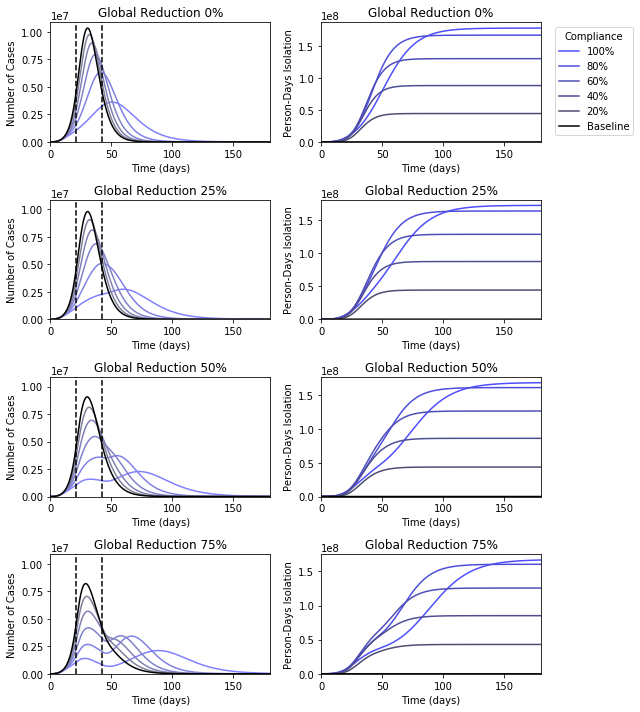

In [14]:
percred = 100*np.ones((lg,lc))
persdays = np.zeros((lg,lc))

plt.figure(figsize=(9,2.5*lg))
for g in range(0,lg):
    plt.subplot(lg,2,2*g+1)
    for c in range(lc-1,0,-1):
        plt.plot(trange,(Npop/nbar)*prev[g,c,:],label= '{:.0f}% compliance'.format(100*comply_range[c]),c=[0.5, 0.5, 0.5+(0.5*comply_range[c])])
        percred[g,c] = 100.0*(np.max(prev[g,c,:])/np.max(prev[0,0,:]))
    plt.plot(trange,(Npop/nbar)*prev[g,0,:],label='Baseline',c=[0, 0, 0])
    yup = 1.05*(Npop/nbar)*np.max(prev[0,0,:])
    plt.plot([dist_start, dist_start],[0,yup],ls='--',c='k')
    plt.plot([dist_end, dist_end],[0,yup],ls='--',c='k')
    plt.xlim([0, trange[tend-1]])
    plt.ylim([0,yup])
    plt.xlabel('Time (days)')
    plt.ylabel('Number of Cases')
    plt.title('Global Reduction {:.0f}%'.format(100*globred_range[g]))
    plt.subplot(lg,2,2*g+2)
    for c in range(lc-1,0,-1):
        plt.plot(trange,(Npop/nbar)*pdi[g,c,:],label= '{:.0f}%'.format(100*comply_range[c]),c=[0.3, 0.3, 0.3+(0.7*comply_range[c])])
        persdays[g,c] = (Npop/nbar)*pdi[g,c,-2]
    plt.plot(trange,(Npop/nbar)*pdi[g,0,:],label='Baseline',c=[0, 0, 0])
    plt.xlim([0, trange[tend-1]])
    plt.ylim([0,1.05*np.max((Npop/nbar)*pdi[g,lc-1,:])])
    if (g==0):
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Compliance")                                                          
    plt.xlabel('Time (days)')
    plt.ylabel('Person-Days Isolation')
    plt.title('Global Reduction {:.0f}%'.format(100*globred_range[g]))
plt.tight_layout()
plt.savefig("./time_series_weak.pdf",format='pdf')

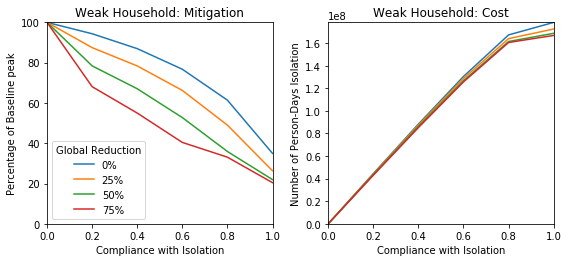

In [15]:
plt.figure(figsize=(8,3.75))
plt.subplot(1,2,1)
for g in range(0,lg):
    plt.plot(comply_range,percred[g,:], label='{:.0f}%'.format(100*globred_range[g]))
plt.xlabel('Compliance with Isolation')
plt.ylabel('Percentage of Baseline peak')
plt.title('Weak Household: Mitigation')
plt.xlim([0,1])
plt.ylim([0,100])
plt.legend(title="Global Reduction")
plt.subplot(1,2,2)
for g in range(0,lg):
    plt.plot(comply_range,persdays[g,:])
plt.xlabel('Compliance with Isolation')
plt.ylabel('Number of Person-Days Isolation')
plt.title('Weak Household: Cost')
plt.xlim([0,1])
plt.ylim([0,np.ceil(np.max(persdays))])
plt.tight_layout()
plt.savefig("./mit_costs_weak.pdf",format='pdf')

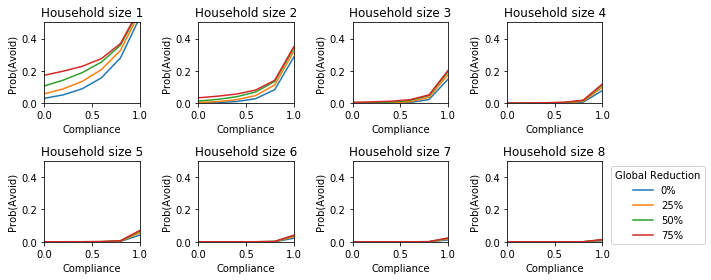

In [16]:
plt.figure(figsize=(10,4))
for n in range(1,nmax+1):
    plt.subplot(2,4,n)
    for g in range(0,lg):
        plt.plot(comply_range,prav[n-1,g,:], label='{:.0f}%'.format(100*globred_range[g]))
        plt.xlim([0, 1.0])
        plt.ylim([0,0.5])
        plt.xlabel('Compliance')
        plt.ylabel('Prob(Avoid)')
        plt.title("Household size " + str(int(n)))
    if n==nmax:
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title="Global Reduction")
plt.tight_layout()
plt.savefig("./prob_avoid_weak.pdf",format='pdf')